# 第36章: 変分オートエンコーダ（VAE）

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] VAEの理論的背景を理解できる
- [ ] VAEをPyTorchで実装できる
- [ ] MNISTで画像生成を行える
- [ ] 潜在空間を可視化・解釈できる
- [ ] VAEのハイパーパラメータを調整できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 34（EMアルゴリズム、ELBO）
- ✅ Notebook 35（PyTorch基礎）
- ✅ 確率分布とKLダイバージェンス

⏱️ **推定学習時間**: 180-240分  
📊 **難易度**: ★★★★☆（上級）  
🎓 **カテゴリ**: 実践・応用

---

## 🌟 はじめに

**VAE（Variational Autoencoder）**は、2013年にKingmaとWellingによって提案された生成モデルです。

### 🤔 なぜVAEを学ぶのか？

1. **生成モデルの基礎**: 拡散モデルの理解に直結
2. **潜在空間の学習**: データの本質的な構造を捉える
3. **変分推論の実践**: ELBOを実際に最適化
4. **実用的な応用**: 画像生成、異常検知、データ拡張

### 📊 VAEの全体像

```
入力 x → [エンコーダ] → (μ, σ) → [サンプリング] → z → [デコーダ] → x̂（再構成）
```

VAEは、**データを低次元の潜在空間に圧縮し、そこから元のデータを再構成**するモデルです。

In [1]:
# ============================================================
# 環境設定
# 必要なライブラリをインポートします
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 警告を非表示
warnings.filterwarnings('ignore')

# グラフスタイルの設定
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic',
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')

# 再現性のための乱数シード
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
PyTorch version: 2.9.1
Device: mps
✅ ライブラリのインポート完了


---

## 1. VAEの理論

### 🤔 通常のオートエンコーダとの違い

| 項目 | オートエンコーダ (AE) | 変分オートエンコーダ (VAE) |
|------|---------------------|---------------------------|
| 潜在変数 | 決定論的な値 | 確率分布 N(μ, σ²) |
| 損失関数 | 再構成誤差のみ | 再構成誤差 + KL損失 |
| 生成能力 | 限定的 | 潜在空間からサンプリング可能 |
| 潜在空間 | 不連続になりやすい | 滑らかで連続的 |

### 📊 VAEの目的関数（ELBO）

VAEはELBO（Evidence Lower Bound）を最大化します：

$$\mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) \| p(z))$$

- **第1項（再構成項）**: デコーダがどれだけ正確に入力を再現できるか
- **第2項（KL項）**: エンコーダの出力が事前分布p(z)にどれだけ近いか

### 📊 損失関数として書き直すと

$$\text{Loss} = -\mathcal{L} = \underbrace{-\mathbb{E}_{q}[\log p(x|z)]}_{\text{再構成誤差}} + \underbrace{D_{KL}(q(z|x) \| p(z))}_{\text{KL正則化}}$$

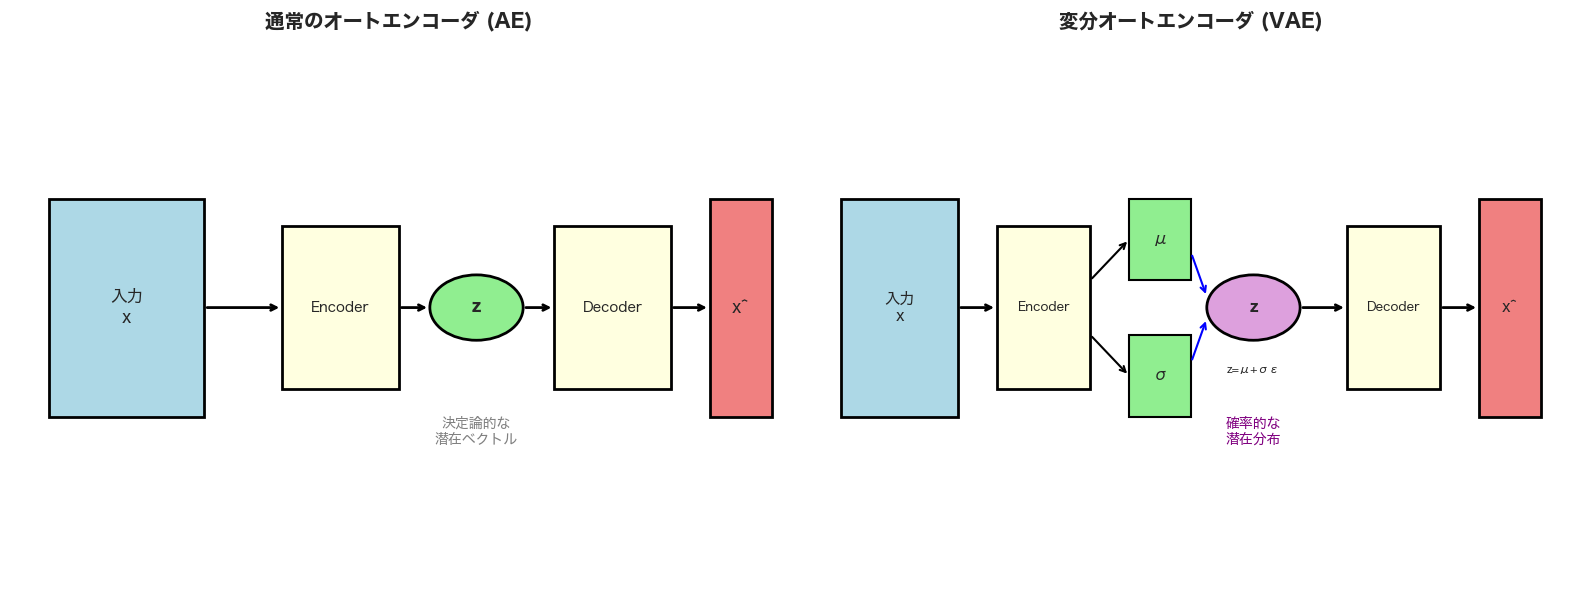

In [2]:
# ============================================================
# AEとVAEの違いを可視化
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左: 通常のオートエンコーダ
ax = axes[0]
ax.set_title('通常のオートエンコーダ (AE)', fontsize=14, fontweight='bold')

# ボックス
ax.add_patch(plt.Rectangle((0.05, 0.3), 0.2, 0.4, color='lightblue', ec='black', lw=2))
ax.text(0.15, 0.5, '入力\nx', ha='center', va='center', fontsize=12)

ax.add_patch(plt.Rectangle((0.35, 0.35), 0.15, 0.3, color='lightyellow', ec='black', lw=2))
ax.text(0.425, 0.5, 'Encoder', ha='center', va='center', fontsize=10)

ax.add_patch(plt.Circle((0.6, 0.5), 0.06, color='lightgreen', ec='black', lw=2))
ax.text(0.6, 0.5, 'z', ha='center', va='center', fontsize=12, fontweight='bold')

ax.add_patch(plt.Rectangle((0.7, 0.35), 0.15, 0.3, color='lightyellow', ec='black', lw=2))
ax.text(0.775, 0.5, 'Decoder', ha='center', va='center', fontsize=10)

ax.add_patch(plt.Rectangle((0.9, 0.3), 0.08, 0.4, color='lightcoral', ec='black', lw=2))
ax.text(0.94, 0.5, 'x̂', ha='center', va='center', fontsize=12)

# 矢印
for (x1, x2) in [(0.25, 0.35), (0.5, 0.54), (0.66, 0.7), (0.85, 0.9)]:
    ax.annotate('', xy=(x2, 0.5), xytext=(x1, 0.5),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

ax.text(0.6, 0.25, '決定論的な\n潜在ベクトル', ha='center', fontsize=10, color='gray')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# 右: VAE
ax = axes[1]
ax.set_title('変分オートエンコーダ (VAE)', fontsize=14, fontweight='bold')

# ボックス
ax.add_patch(plt.Rectangle((0.05, 0.3), 0.15, 0.4, color='lightblue', ec='black', lw=2))
ax.text(0.125, 0.5, '入力\nx', ha='center', va='center', fontsize=11)

ax.add_patch(plt.Rectangle((0.25, 0.35), 0.12, 0.3, color='lightyellow', ec='black', lw=2))
ax.text(0.31, 0.5, 'Encoder', ha='center', va='center', fontsize=9)

# μとσ
ax.add_patch(plt.Rectangle((0.42, 0.55), 0.08, 0.15, color='lightgreen', ec='black', lw=1.5))
ax.text(0.46, 0.625, 'μ', ha='center', va='center', fontsize=11)

ax.add_patch(plt.Rectangle((0.42, 0.3), 0.08, 0.15, color='lightgreen', ec='black', lw=1.5))
ax.text(0.46, 0.375, 'σ', ha='center', va='center', fontsize=11)

# サンプリング
ax.add_patch(plt.Circle((0.58, 0.5), 0.06, color='plum', ec='black', lw=2))
ax.text(0.58, 0.5, 'z', ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(0.58, 0.38, 'z=μ+σε', ha='center', fontsize=8)

ax.add_patch(plt.Rectangle((0.7, 0.35), 0.12, 0.3, color='lightyellow', ec='black', lw=2))
ax.text(0.76, 0.5, 'Decoder', ha='center', va='center', fontsize=9)

ax.add_patch(plt.Rectangle((0.87, 0.3), 0.08, 0.4, color='lightcoral', ec='black', lw=2))
ax.text(0.91, 0.5, 'x̂', ha='center', va='center', fontsize=11)

# 矢印
ax.annotate('', xy=(0.25, 0.5), xytext=(0.2, 0.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.annotate('', xy=(0.42, 0.625), xytext=(0.37, 0.55),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(0.42, 0.375), xytext=(0.37, 0.45),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(0.52, 0.52), xytext=(0.5, 0.6),
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))
ax.annotate('', xy=(0.52, 0.48), xytext=(0.5, 0.4),
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))
ax.annotate('', xy=(0.7, 0.5), xytext=(0.64, 0.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.annotate('', xy=(0.87, 0.5), xytext=(0.82, 0.5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

ax.text(0.58, 0.25, '確率的な\n潜在分布', ha='center', fontsize=10, color='purple')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.show()

---

## 2. MNISTデータセットの準備

MNISTは、手書き数字（0-9）の28×28ピクセルのグレースケール画像データセットです。

In [3]:
# ============================================================
# MNISTデータセットの読み込み
# ============================================================

print("="*60)
print("MNISTデータセットの準備")
print("="*60)

# データの前処理
transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 255] -> [0, 1]
])

# 訓練データとテストデータ
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# データローダー
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n訓練データ: {len(train_dataset)} 枚")
print(f"テストデータ: {len(test_dataset)} 枚")
print(f"画像サイズ: 28 × 28 = 784 ピクセル")
print(f"バッチサイズ: {batch_size}")

MNISTデータセットの準備


100%|██████████| 9.91M/9.91M [00:10<00:00, 903kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 702kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.20MB/s]


訓練データ: 60000 枚
テストデータ: 10000 枚
画像サイズ: 28 × 28 = 784 ピクセル
バッチサイズ: 128


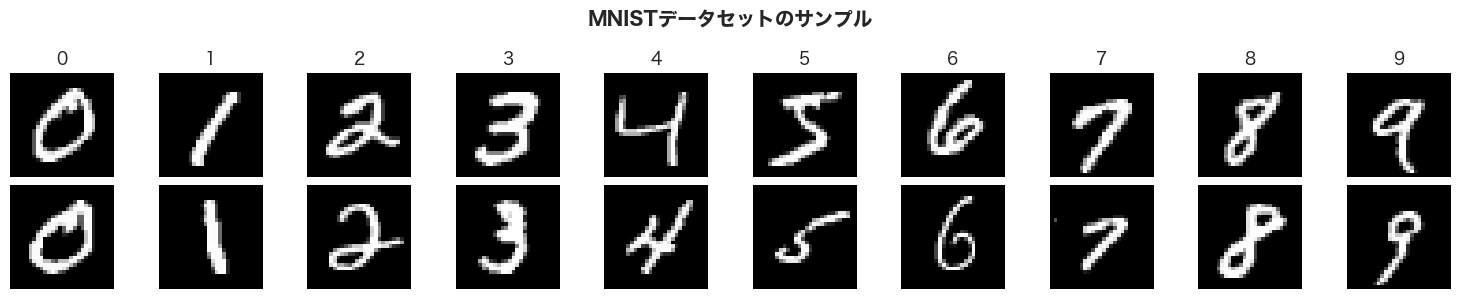

In [4]:
# ============================================================
# サンプル画像の表示
# ============================================================

fig, axes = plt.subplots(2, 10, figsize=(15, 3))

for i in range(10):
    # 各数字のサンプルを2枚ずつ表示
    for j in range(2):
        idx = np.where(np.array(train_dataset.targets) == i)[0][j]
        img = train_dataset.data[idx].numpy()
        axes[j, i].imshow(img, cmap='gray')
        axes[j, i].axis('off')
        if j == 0:
            axes[j, i].set_title(str(i), fontsize=12)

plt.suptitle('MNISTデータセットのサンプル', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 3. VAEモデルの実装

### 📊 モデル構成

- **エンコーダ**: 784 → 256 → 128 → (μ, log σ²) (各latent_dim次元)
- **デコーダ**: latent_dim → 128 → 256 → 784

In [5]:
# ============================================================
# VAEモデルの定義
# ============================================================

class VAE(nn.Module):
    """
    変分オートエンコーダ (Variational Autoencoder)
    
    構成:
    - エンコーダ: 入力 → 潜在分布のパラメータ (μ, log σ²)
    - 再パラメータ化: z = μ + σ * ε
    - デコーダ: z → 再構成画像
    """
    
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=2):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        # エンコーダ
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        
        # 潜在分布のパラメータ
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        
        # デコーダ
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),  # 出力を[0, 1]に正規化
        )
    
    def encode(self, x):
        """エンコーダ: 入力 → (μ, log σ²)"""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """
        再パラメータ化トリック
        z = μ + σ * ε, where ε ~ N(0, I)
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decode(self, z):
        """デコーダ: z → 再構成"""
        return self.decoder(z)
    
    def forward(self, x):
        """順伝播: 入力 → 再構成, μ, log σ²"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    
    def sample(self, num_samples, device='cpu'):
        """潜在空間からサンプリングして画像を生成"""
        z = torch.randn(num_samples, self.latent_dim).to(device)
        return self.decode(z)

# モデルを作成
latent_dim = 2  # 可視化のため2次元に
model = VAE(input_dim=784, hidden_dim=256, latent_dim=latent_dim).to(device)

print(model)
print(f"\n潜在空間の次元: {latent_dim}")

# パラメータ数
total_params = sum(p.numel() for p in model.parameters())
print(f"総パラメータ数: {total_params:,}")

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

潜在空間の次元: 2
総パラメータ数: 469,268


In [6]:
# ============================================================
# 損失関数の定義
# ============================================================

def vae_loss(x, x_recon, mu, logvar, beta=1.0):
    """
    VAEの損失関数
    
    Loss = 再構成誤差 + β * KLダイバージェンス
    
    Parameters:
    -----------
    x : 元の入力
    x_recon : 再構成された出力
    mu : 潜在分布の平均
    logvar : 潜在分布の対数分散
    beta : KL項の重み（β-VAE用）
    
    Returns:
    --------
    total_loss, recon_loss, kl_loss
    """
    batch_size = x.size(0)
    
    # 再構成誤差（Binary Cross Entropy）
    # 各ピクセルのBCEを計算し、バッチで平均
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / batch_size
    
    # KLダイバージェンス
    # D_KL(N(μ, σ²) || N(0, 1)) = -0.5 * Σ(1 + log σ² - μ² - σ²)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
    
    # 総損失
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

print("✅ 損失関数を定義しました")
print("\n損失関数の構成:")
print("  L = 再構成誤差 + β × KL損失")
print("  再構成誤差: BCE(x, x̂)")
print("  KL損失: D_KL(q(z|x) || p(z))")

✅ 損失関数を定義しました

損失関数の構成:
  L = 再構成誤差 + β × KL損失
  再構成誤差: BCE(x, x̂)
  KL損失: D_KL(q(z|x) || p(z))


---

## 4. モデルの学習

VAEを訓練します。学習中に以下を記録します：
- 総損失
- 再構成誤差
- KLダイバージェンス

In [7]:
# ============================================================
# 学習関数の定義
# ============================================================

def train_epoch(model, train_loader, optimizer, device, beta=1.0):
    """1エポックの学習"""
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        # データをデバイスに転送し、フラット化
        data = data.view(-1, 784).to(device)
        
        # 勾配をリセット
        optimizer.zero_grad()
        
        # 順伝播
        x_recon, mu, logvar = model(data)
        
        # 損失を計算
        loss, recon, kl = vae_loss(data, x_recon, mu, logvar, beta)
        
        # 逆伝播
        loss.backward()
        
        # パラメータ更新
        optimizer.step()
        
        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
    
    n_batches = len(train_loader)
    return total_loss / n_batches, total_recon / n_batches, total_kl / n_batches


def evaluate(model, test_loader, device, beta=1.0):
    """評価"""
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, 784).to(device)
            x_recon, mu, logvar = model(data)
            loss, recon, kl = vae_loss(data, x_recon, mu, logvar, beta)
            
            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()
    
    n_batches = len(test_loader)
    return total_loss / n_batches, total_recon / n_batches, total_kl / n_batches

print("✅ 学習・評価関数を定義しました")

✅ 学習・評価関数を定義しました


In [8]:
# ============================================================
# モデルの学習
# ============================================================

# ハイパーパラメータ
n_epochs = 30
learning_rate = 1e-3
beta = 1.0  # KL項の重み

# モデルとオプティマイザ
model = VAE(input_dim=784, hidden_dim=256, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 学習履歴
history = {
    'train_loss': [], 'train_recon': [], 'train_kl': [],
    'test_loss': [], 'test_recon': [], 'test_kl': []
}

print("="*60)
print("VAEの学習")
print("="*60)
print(f"エポック数: {n_epochs}")
print(f"学習率: {learning_rate}")
print(f"潜在次元: {latent_dim}")
print(f"β: {beta}")
print("-"*60)

for epoch in range(n_epochs):
    # 学習
    train_loss, train_recon, train_kl = train_epoch(model, train_loader, optimizer, device, beta)
    
    # 評価
    test_loss, test_recon, test_kl = evaluate(model, test_loader, device, beta)
    
    # 履歴を保存
    history['train_loss'].append(train_loss)
    history['train_recon'].append(train_recon)
    history['train_kl'].append(train_kl)
    history['test_loss'].append(test_loss)
    history['test_recon'].append(test_recon)
    history['test_kl'].append(test_kl)
    
    # 進捗表示
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{n_epochs}: "
              f"Loss={train_loss:.2f} (Recon={train_recon:.2f}, KL={train_kl:.2f}) | "
              f"Test Loss={test_loss:.2f}")

print("-"*60)
print("✅ 学習完了！")

VAEの学習
エポック数: 30
学習率: 0.001
潜在次元: 2
β: 1.0
------------------------------------------------------------
Epoch   1/30: Loss=191.10 (Recon=187.43, KL=3.67) | Test Loss=168.59
Epoch   5/30: Loss=152.60 (Recon=146.87, KL=5.73) | Test Loss=151.15
Epoch  10/30: Loss=146.03 (Recon=139.86, KL=6.17) | Test Loss=145.90
Epoch  15/30: Loss=143.04 (Recon=136.68, KL=6.37) | Test Loss=143.50
Epoch  20/30: Loss=141.21 (Recon=134.70, KL=6.50) | Test Loss=142.16
Epoch  25/30: Loss=140.18 (Recon=133.59, KL=6.59) | Test Loss=141.56
Epoch  30/30: Loss=139.11 (Recon=132.46, KL=6.65) | Test Loss=140.83
------------------------------------------------------------
✅ 学習完了！


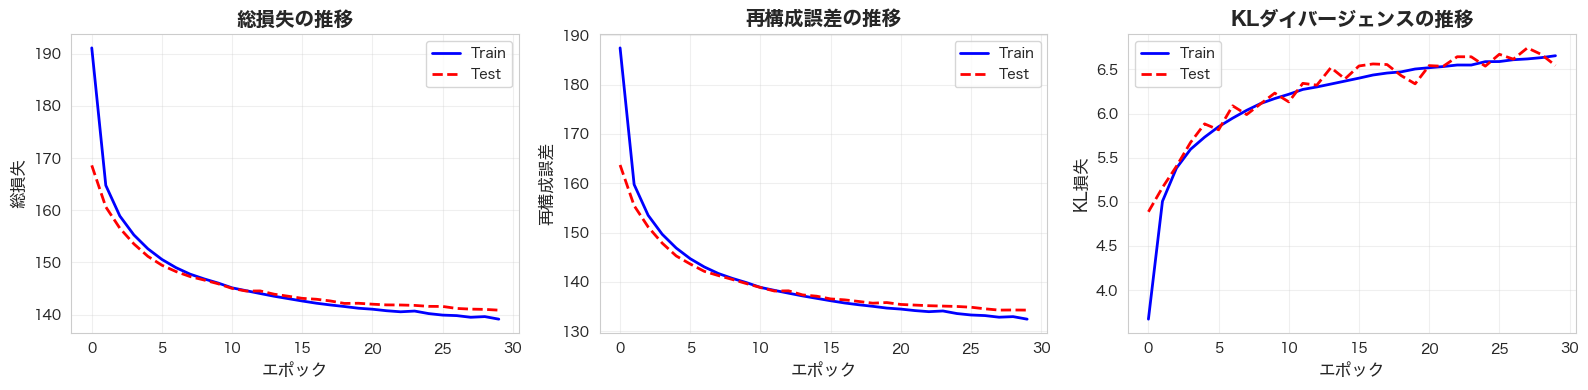

In [9]:
# ============================================================
# 学習曲線の可視化
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 総損失
ax = axes[0]
ax.plot(history['train_loss'], 'b-', label='Train', linewidth=2)
ax.plot(history['test_loss'], 'r--', label='Test', linewidth=2)
ax.set_xlabel('エポック', fontsize=12)
ax.set_ylabel('総損失', fontsize=12)
ax.set_title('総損失の推移', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 再構成誤差
ax = axes[1]
ax.plot(history['train_recon'], 'b-', label='Train', linewidth=2)
ax.plot(history['test_recon'], 'r--', label='Test', linewidth=2)
ax.set_xlabel('エポック', fontsize=12)
ax.set_ylabel('再構成誤差', fontsize=12)
ax.set_title('再構成誤差の推移', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# KLダイバージェンス
ax = axes[2]
ax.plot(history['train_kl'], 'b-', label='Train', linewidth=2)
ax.plot(history['test_kl'], 'r--', label='Test', linewidth=2)
ax.set_xlabel('エポック', fontsize=12)
ax.set_ylabel('KL損失', fontsize=12)
ax.set_title('KLダイバージェンスの推移', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. 再構成結果の確認

学習済みVAEで、入力画像がどの程度正確に再構成されるか確認します。

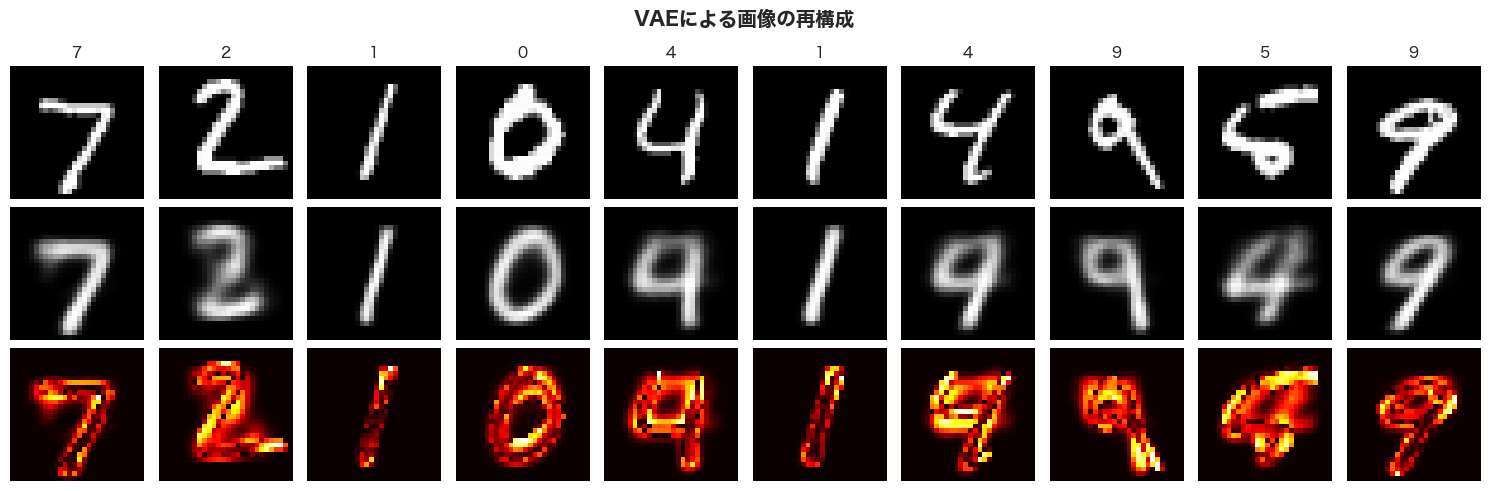

In [10]:
# ============================================================
# 再構成結果の可視化
# ============================================================

model.eval()

# テストデータからサンプルを取得
test_data, test_labels = next(iter(test_loader))
test_data = test_data[:10].view(-1, 784).to(device)

# 再構成
with torch.no_grad():
    x_recon, mu, logvar = model(test_data)

# 可視化
fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i in range(10):
    # 元の画像
    axes[0, i].imshow(test_data[i].cpu().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('入力', fontsize=12)
    
    # 再構成画像
    axes[1, i].imshow(x_recon[i].cpu().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('再構成', fontsize=12)
    
    # 差分
    diff = np.abs(test_data[i].cpu().numpy() - x_recon[i].cpu().numpy()).reshape(28, 28)
    axes[2, i].imshow(diff, cmap='hot')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('差分', fontsize=12)
    
    axes[0, i].set_title(f'{test_labels[i].item()}', fontsize=11)

plt.suptitle('VAEによる画像の再構成', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 6. 潜在空間の可視化

2次元の潜在空間を可視化して、VAEが学習した表現を確認します。

In [11]:
# ============================================================
# 潜在空間の可視化
# ============================================================

model.eval()

# 全テストデータを潜在空間にエンコード
all_z = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.view(-1, 784).to(device)
        mu, logvar = model.encode(data)
        all_z.append(mu.cpu().numpy())
        all_labels.append(labels.numpy())

all_z = np.concatenate(all_z, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(f"潜在ベクトル: {all_z.shape}")
print(f"ラベル: {all_labels.shape}")

潜在ベクトル: (10000, 2)
ラベル: (10000,)


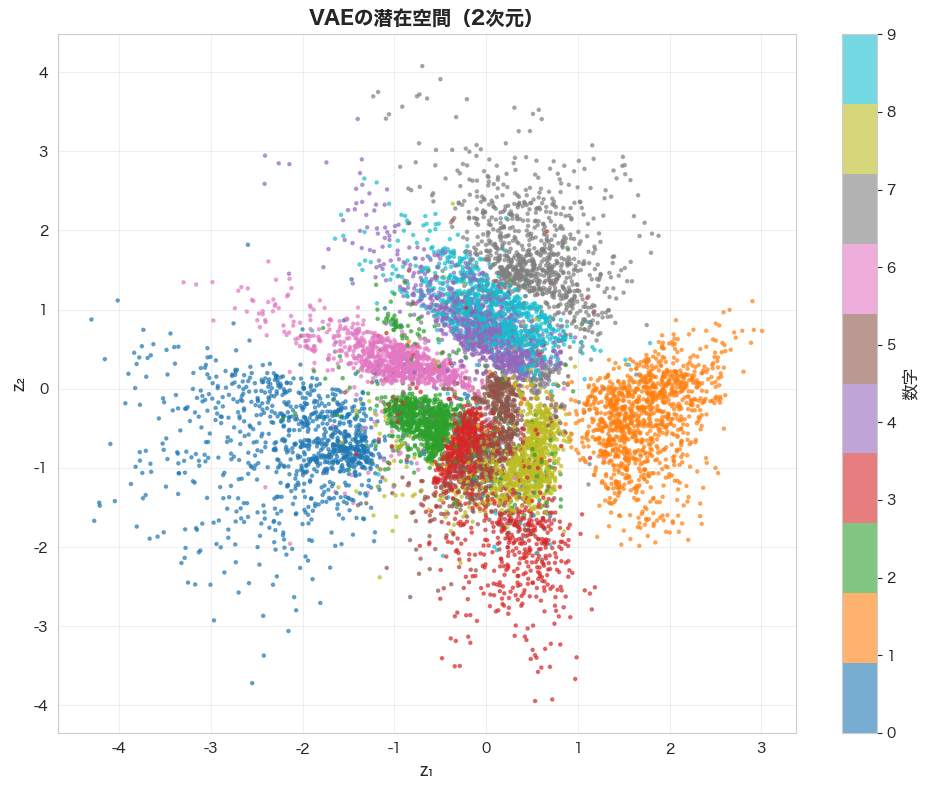

💡 観察ポイント:
  - 同じ数字が近くに集まっている
  - 似た形の数字（0と6、3と8など）が近い位置にある
  - 潜在空間が連続的（穴がない）


In [12]:
# ============================================================
# 潜在空間の散布図
# ============================================================

fig, ax = plt.subplots(figsize=(10, 8))

# 各数字で色分け
scatter = ax.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', 
                     s=5, alpha=0.6)

# カラーバー
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('数字', fontsize=12)

ax.set_xlabel('z₁', fontsize=12)
ax.set_ylabel('z₂', fontsize=12)
ax.set_title('VAEの潜在空間（2次元）', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 観察ポイント:")
print("  - 同じ数字が近くに集まっている")
print("  - 似た形の数字（0と6、3と8など）が近い位置にある")
print("  - 潜在空間が連続的（穴がない）")

---

## 7. 画像生成

潜在空間からサンプリングして、新しい画像を生成します。

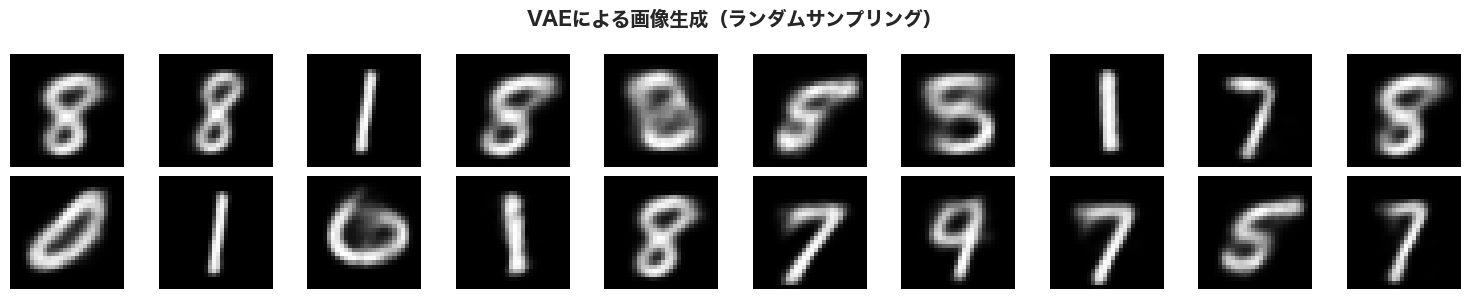

In [13]:
# ============================================================
# ランダムサンプリングによる画像生成
# ============================================================

model.eval()

# 標準正規分布からサンプリング
n_samples = 20
z_random = torch.randn(n_samples, latent_dim).to(device)

with torch.no_grad():
    generated = model.decode(z_random)

# 可視化
fig, axes = plt.subplots(2, 10, figsize=(15, 3))

for i in range(n_samples):
    row = i // 10
    col = i % 10
    axes[row, col].imshow(generated[i].cpu().numpy().reshape(28, 28), cmap='gray')
    axes[row, col].axis('off')

plt.suptitle('VAEによる画像生成（ランダムサンプリング）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

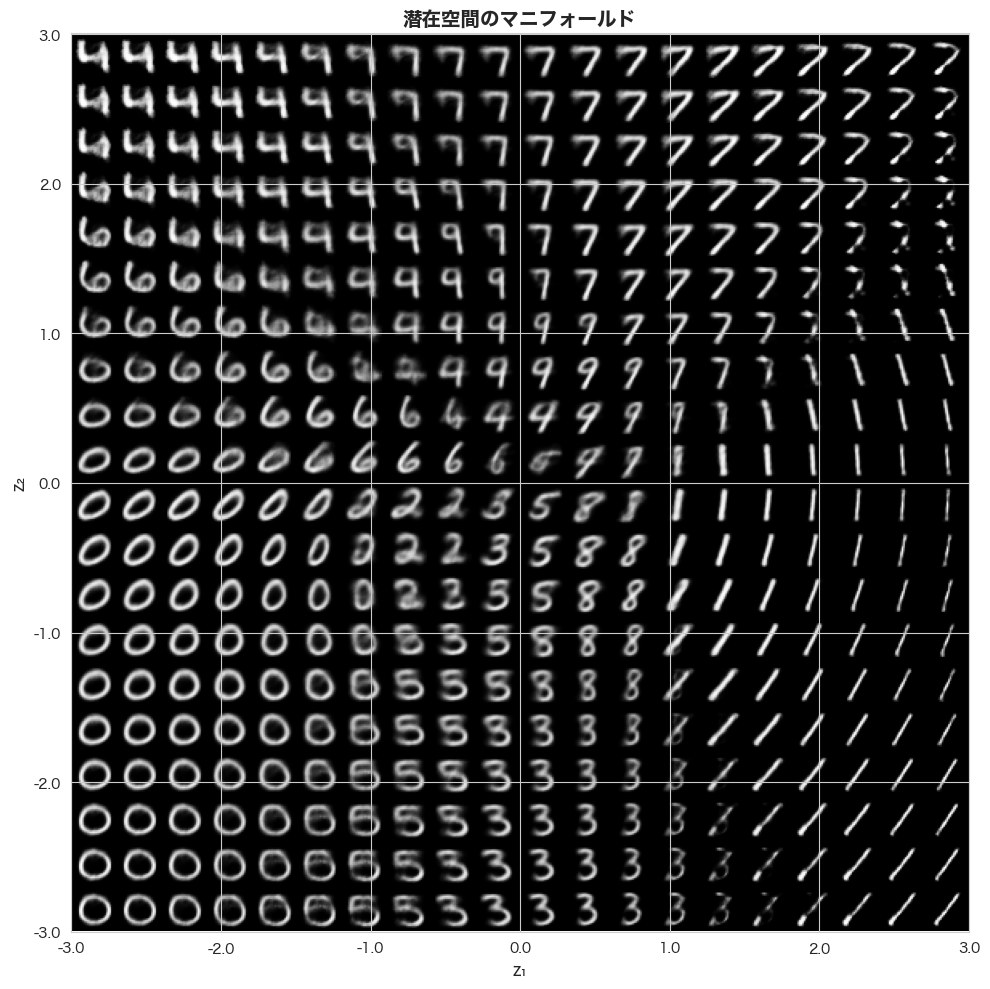

💡 観察ポイント:
  - 潜在空間を連続的に移動すると、画像も滑らかに変化
  - 異なる数字間の補間（モーフィング）が見られる
  - 中心付近（z≈0）に多くの数字が集中


In [14]:
# ============================================================
# 潜在空間のグリッドからの生成
# 2次元潜在空間を格子状にサンプリング
# ============================================================

model.eval()

# グリッドを作成
n_grid = 20
z_range = np.linspace(-3, 3, n_grid)

# 全グリッド点を生成
grid_images = []

with torch.no_grad():
    for z2 in reversed(z_range):  # 上から下へ
        row_images = []
        for z1 in z_range:
            z = torch.tensor([[z1, z2]], dtype=torch.float32).to(device)
            img = model.decode(z)
            row_images.append(img.cpu().numpy().reshape(28, 28))
        grid_images.append(row_images)

# 1つの大きな画像に結合
full_image = np.zeros((n_grid * 28, n_grid * 28))
for i, row in enumerate(grid_images):
    for j, img in enumerate(row):
        full_image[i*28:(i+1)*28, j*28:(j+1)*28] = img

# 可視化
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(full_image, cmap='gray')
ax.set_xlabel('z₁', fontsize=12)
ax.set_ylabel('z₂', fontsize=12)
ax.set_title('潜在空間のマニフォールド', fontsize=14, fontweight='bold')

# 軸ラベルを調整
ticks = np.linspace(0, n_grid * 28, 7)
tick_labels = np.linspace(-3, 3, 7)
ax.set_xticks(ticks)
ax.set_xticklabels([f'{x:.1f}' for x in tick_labels])
ax.set_yticks(ticks)
ax.set_yticklabels([f'{x:.1f}' for x in reversed(tick_labels)])

plt.tight_layout()
plt.show()

print("💡 観察ポイント:")
print("  - 潜在空間を連続的に移動すると、画像も滑らかに変化")
print("  - 異なる数字間の補間（モーフィング）が見られる")
print("  - 中心付近（z≈0）に多くの数字が集中")

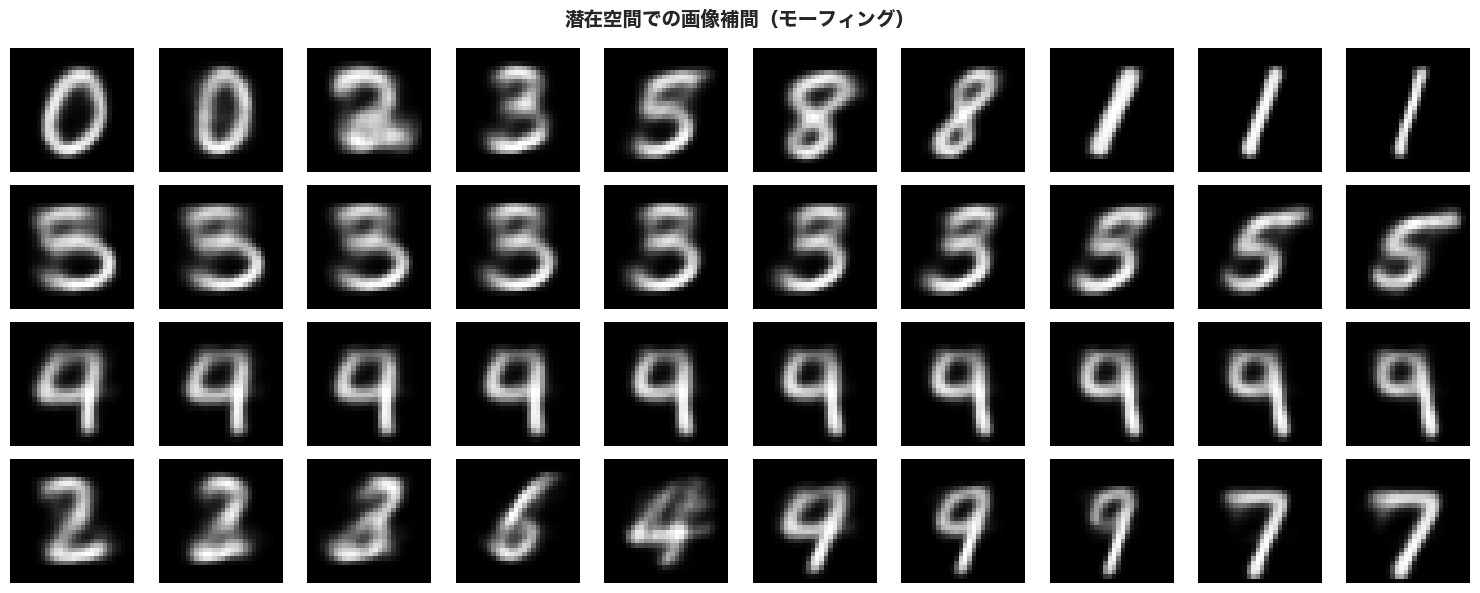

In [15]:
# ============================================================
# 画像間の補間（モーフィング）
# ============================================================

model.eval()

def interpolate(model, x1, x2, n_steps=10):
    """2つの画像間を補間"""
    with torch.no_grad():
        # 潜在ベクトルを取得
        mu1, _ = model.encode(x1)
        mu2, _ = model.encode(x2)
        
        # 線形補間
        interpolated = []
        for alpha in np.linspace(0, 1, n_steps):
            z = (1 - alpha) * mu1 + alpha * mu2
            img = model.decode(z)
            interpolated.append(img.cpu().numpy().reshape(28, 28))
    
    return interpolated

# 異なる数字のペアで補間
pairs = [(0, 1), (3, 8), (4, 9), (2, 7)]
n_steps = 10

fig, axes = plt.subplots(len(pairs), n_steps, figsize=(15, 6))

for row, (digit1, digit2) in enumerate(pairs):
    # 各数字のサンプルを取得
    idx1 = np.where(np.array(test_dataset.targets) == digit1)[0][0]
    idx2 = np.where(np.array(test_dataset.targets) == digit2)[0][0]
    
    x1 = test_dataset.data[idx1].float().view(1, 784).to(device) / 255.0
    x2 = test_dataset.data[idx2].float().view(1, 784).to(device) / 255.0
    
    # 補間
    interpolated = interpolate(model, x1, x2, n_steps)
    
    for col, img in enumerate(interpolated):
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
    
    axes[row, 0].set_ylabel(f'{digit1}→{digit2}', fontsize=11)

plt.suptitle('潜在空間での画像補間（モーフィング）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 8. β-VAE: 表現学習の改善

**β-VAE**は、KL項の重みβを調整することで、より解釈しやすい潜在表現を学習します。

$$\text{Loss} = \text{再構成誤差} + \beta \cdot D_{KL}(q(z|x) \| p(z))$$

- **β < 1**: 再構成を重視（より正確な再構成）
- **β = 1**: 標準VAE
- **β > 1**: KLを重視（より解釈しやすい表現）

In [16]:
# ============================================================
# β-VAEの比較
# 異なるβ値での学習結果を比較します
# ============================================================

print("="*60)
print("β-VAEの比較実験")
print("="*60)

beta_values = [0.1, 1.0, 4.0]
models_beta = {}

for beta in beta_values:
    print(f"\nβ = {beta} で学習中...")
    
    # モデルを作成
    model_beta = VAE(input_dim=784, hidden_dim=256, latent_dim=2).to(device)
    optimizer_beta = optim.Adam(model_beta.parameters(), lr=1e-3)
    
    # 短いエポック数で学習
    for epoch in range(15):
        train_epoch(model_beta, train_loader, optimizer_beta, device, beta=beta)
    
    models_beta[beta] = model_beta
    
    # 評価
    test_loss, test_recon, test_kl = evaluate(model_beta, test_loader, device, beta=beta)
    print(f"  Test - Loss: {test_loss:.2f}, Recon: {test_recon:.2f}, KL: {test_kl:.2f}")

print("\n✅ 学習完了！")

β-VAEの比較実験

β = 0.1 で学習中...
  Test - Loss: 136.69, Recon: 135.66, KL: 10.27

β = 1.0 で学習中...
  Test - Loss: 145.89, Recon: 139.51, KL: 6.38

β = 4.0 で学習中...
  Test - Loss: 161.53, Recon: 143.68, KL: 4.46

✅ 学習完了！


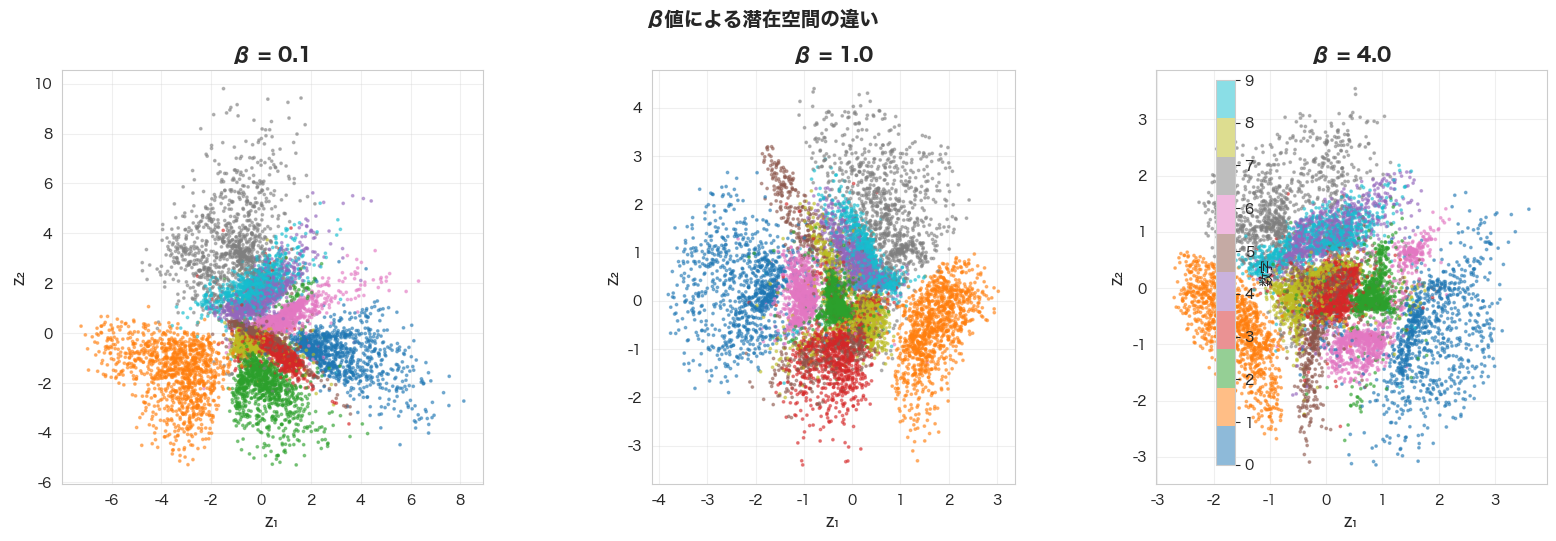

💡 観察ポイント:
  β = 0.1: 再構成重視 → クラスタが分離しやすい
  β = 1.0: バランス → 標準VAE
  β = 4.0: KL重視 → N(0,1)に近い、より滑らかな潜在空間


In [17]:
# ============================================================
# β値による潜在空間の違い
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, beta in enumerate(beta_values):
    model_beta = models_beta[beta]
    model_beta.eval()
    
    # テストデータをエンコード
    all_z = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.view(-1, 784).to(device)
            mu, _ = model_beta.encode(data)
            all_z.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    
    all_z = np.concatenate(all_z, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # プロット
    ax = axes[idx]
    scatter = ax.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', s=3, alpha=0.5)
    ax.set_xlabel('z₁', fontsize=12)
    ax.set_ylabel('z₂', fontsize=12)
    ax.set_title(f'β = {beta}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.colorbar(scatter, ax=axes.ravel().tolist(), label='数字', ticks=range(10))
plt.suptitle('β値による潜在空間の違い', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("💡 観察ポイント:")
print("  β = 0.1: 再構成重視 → クラスタが分離しやすい")
print("  β = 1.0: バランス → 標準VAE")
print("  β = 4.0: KL重視 → N(0,1)に近い、より滑らかな潜在空間")

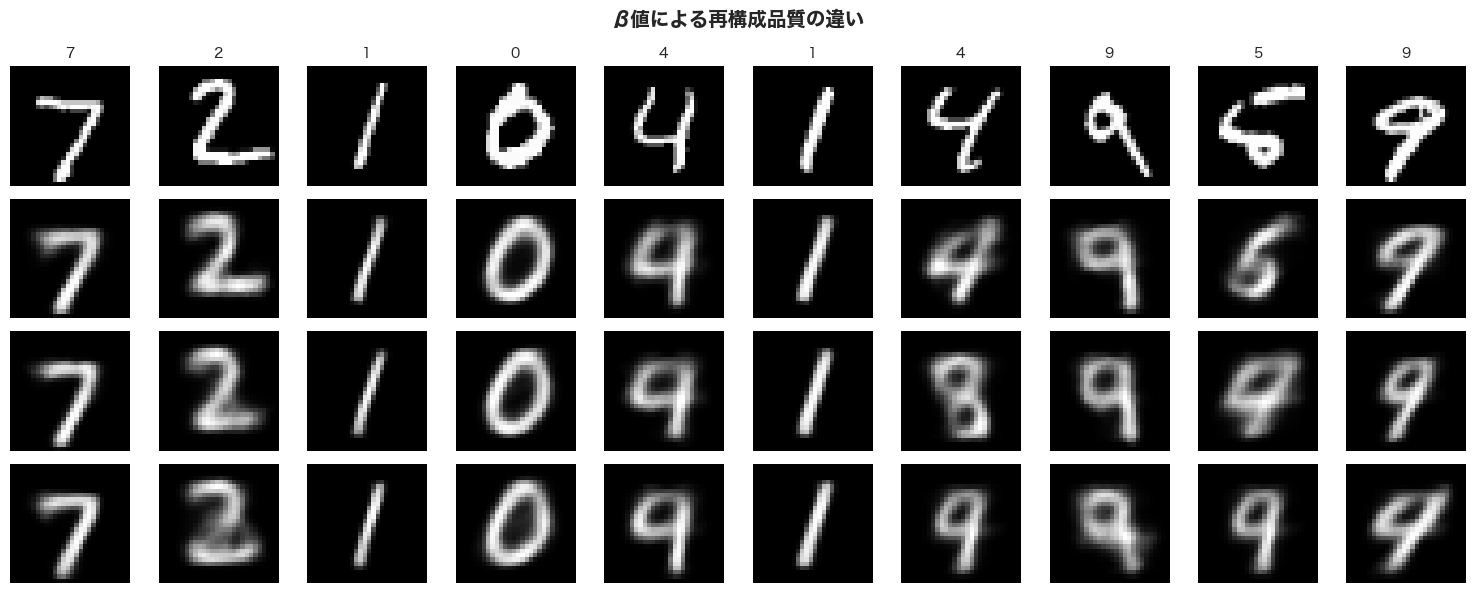

In [18]:
# ============================================================
# β値による再構成品質の違い
# ============================================================

fig, axes = plt.subplots(len(beta_values) + 1, 10, figsize=(15, 6))

# テストデータからサンプルを取得
test_data, test_labels = next(iter(test_loader))
test_data_flat = test_data[:10].view(-1, 784).to(device)

# 元の画像
for i in range(10):
    axes[0, i].imshow(test_data_flat[i].cpu().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'{test_labels[i].item()}', fontsize=10)
axes[0, 0].set_ylabel('入力', fontsize=11)

# 各βでの再構成
for row, beta in enumerate(beta_values, 1):
    model_beta = models_beta[beta]
    model_beta.eval()
    
    with torch.no_grad():
        x_recon, _, _ = model_beta(test_data_flat)
    
    for i in range(10):
        axes[row, i].imshow(x_recon[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[row, i].axis('off')
    axes[row, 0].set_ylabel(f'β={beta}', fontsize=11)

plt.suptitle('β値による再構成品質の違い', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## まとめ

### 🎯 このノートブックで学んだこと

**VAEの理論**
- ✓ 変分推論とELBOの関係
- ✓ 再構成誤差とKLダイバージェンスの役割
- ✓ 再パラメータ化トリック

**VAEの実装**
- ✓ エンコーダ・デコーダの構築
- ✓ 損失関数の実装
- ✓ 学習ループの作成

**VAEの応用**
- ✓ 画像の再構成
- ✓ 潜在空間の可視化
- ✓ 新しい画像の生成
- ✓ 画像間の補間（モーフィング）

**β-VAE**
- ✓ β値の意味と効果
- ✓ 表現学習のトレードオフ

### 📊 VAEチートシート

| 項目 | 説明 |
|------|------|
| エンコーダ | x → (μ, log σ²) |
| 再パラメータ化 | z = μ + σ * ε |
| デコーダ | z → x̂ |
| 再構成誤差 | BCE(x, x̂) または MSE |
| KL損失 | -0.5 * Σ(1 + log σ² - μ² - σ²) |
| 総損失 | 再構成誤差 + β * KL損失 |

---

## 🎓 自己評価クイズ

### Q1: VAEの損失関数の2つの項は何を表していますか？

<details>
<summary>💡 答えを見る</summary>

**答え**:

1. **再構成誤差**: 入力画像をどれだけ正確に再構成できるか
   - デコーダの性能を測る
   - 小さいほど良い再構成

2. **KLダイバージェンス**: 潜在分布が事前分布N(0,1)にどれだけ近いか
   - 潜在空間を正則化する効果
   - 滑らかで連続的な潜在空間を促す

</details>

---

### Q2: 再パラメータ化トリックはなぜ必要ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 

サンプリング操作 z ~ N(μ, σ²) は微分不可能なため、勾配が伝播できません。

再パラメータ化トリック z = μ + σ * ε（ε ~ N(0,1)）を使うと、zがμとσの決定論的な関数になり、勾配を計算できます。

</details>

---

### Q3: β-VAEでβ > 1にすると何が起こりますか？

<details>
<summary>💡 答えを見る</summary>

**答え**:

- KL項の重みが大きくなる
- 潜在分布がN(0,1)に近づきやすくなる
- より滑らかで連続的な潜在空間になる
- 再構成品質は低下する可能性がある
- 潜在変数がより独立した（解きほぐされた）表現を学習しやすい

</details>

---

### Q4: VAEが通常のオートエンコーダより生成に適している理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**:

1. **潜在空間の連続性**: KL正則化により、潜在空間が滑らかになる
2. **確率的潜在変数**: N(0,1)からサンプリングするだけで新しい画像を生成できる
3. **意味のある補間**: 潜在空間で線形補間すると、意味のある画像変化が得られる

通常のAEは潜在空間に「穴」ができやすく、そこからサンプリングすると意味のない画像が生成される。

</details>

---

### ✅ 学習チェックリスト

- [ ] VAEの損失関数を説明できる
- [ ] 再パラメータ化トリックを実装できる
- [ ] VAEをPyTorchで実装できる
- [ ] 潜在空間を可視化・解釈できる
- [ ] β-VAEの効果を説明できる

---

**次のステップ**: VAEの基礎をマスターしたら、拡散モデル（Diffusion Models）の学習に進みましょう！

拡散モデルは、VAEの考え方を発展させた、より高品質な画像生成が可能なモデルです。